In [17]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import pickle
from itertools import combinations
import matplotlib.pyplot as plt

In [18]:
df_merged = pd.read_csv("../data/processed_Data/df_merged.csv", dtype=str)

In [19]:
df_merged

,idvotacao,datahoravoto,voto,deputado_id,deputado_nome,deputado_siglapartido,deputado_siglauf,deputado_idlegislatura,aprovacao,year,proposicao_id,proposicao_ano,classification
0,143282-5,2003-11-18T19:02:33,Não,73764,Abelardo Lupion,PFL,PR,52,1,2003,26694.0,2001.0,Approval of Requests
1,143282-5,2003-11-18T19:09:55,Sim,73886,Adão Pretto,PT,RS,52,1,2003,26694.0,2001.0,Approval of Requests
2,143282-5,2003-11-18T18:58:01,Não,73765,Affonso Camargo,PSDB,PR,52,1,2003,26694.0,2001.0,Approval of Requests
3,143282-5,2003-11-18T18:57:59,Sim,74358,Agnaldo Muniz,PPS,RO,52,1,2003,26694.0,2001.0,Approval of Requests
4,143282-5,2003-11-18T19:04:07,Sim,73457,Airton Roveda,PMDB,PR,52,1,2003,26694.0,2001.0,Approval of Requests
...,...,...,...,...,...,...,...,...,...,...,...,...,...
587438,565397-185,2024-10-16T19:58:10,Sim,220536,Zé Haroldo Cathedral,PSD,RR,57,0,2024,565397.0,2013.0,Approval of Substitutes
587439,565397-185,2024-10-16T20:00:02,Não,160632,Zé Silva,SOLIDARIEDADE,MG,57,0,2024,565397.0,2013.0,Approval of Substitutes
587440,565397-185,2024-10-16T19:59:56,Não,204517,Zé Vitor,PL,MG,57,0,2024,565397.0,2013.0,Approval of Substitutes
587441,565397-185,2024-10-16T19:59:29,Não,220592,Zezinho Barbary,PP,AC,57,0,2024,565397.0,2013.0,Approval of Substitutes


In [20]:
df_merged["voto"].unique()

array(['Não', 'Sim', 'Abstenção', 'Artigo 17', 'Obstrução'], dtype=object)

In [21]:
# Classifying votes into categories
df_merged['vote_type'] = df_merged['voto'].apply(lambda x: 'Sim' if x == 'Sim' else 'Não' if x == 'Não' else 'Others')

# Grouping and counting votes
vote_counts = df_merged.groupby(['idvotacao', 'vote_type']).size().unstack(fill_value=0)

# Renaming columns for clarity
vote_counts = vote_counts.rename(columns={'Sim': 'Votes_Sim', 'Não': 'Votes_No', 'Others': 'Others'})

# Ensuring all expected columns exist
for col in ['Votes_Sim', 'Votes_No', 'Others']:
    if col not in vote_counts:
        vote_counts[col] = 0

# Calculating the percentage of 'Sim' votes
vote_counts['%Votes_Sim'] = (vote_counts['Votes_Sim'] / (vote_counts['Votes_Sim'] + vote_counts['Votes_No'] + vote_counts['Others'])) * 100

# Reset index for a cleaner output
vote_counts = vote_counts.reset_index()

# Adding the classification column from the original dataset
vote_counts = vote_counts.merge(df_merged[['idvotacao', 'classification']].drop_duplicates(), on='idvotacao', how='left')


vote_counts

,idvotacao,Votes_No,Others,Votes_Sim,%Votes_Sim,classification
0,1049075-6,116,2,222,65.294118,Approval of Requests
1,1049167-8,4,1,349,98.587571,Approval of Requests
2,1050643-102,110,3,223,66.369048,Approval of Requests
3,1050643-110,213,1,136,38.857143,Approval of Substitutes
4,1050643-113,160,1,211,56.720430,Approval of Substitutes
...,...,...,...,...,...,...
1512,946475-131,2,3,298,98.349835,Approval of Substitutes
1513,946475-138,269,2,2,0.732601,Approval of Final Wording
1514,946625-101,308,1,132,29.931973,Approval of Substitutes
1515,962435-6,1,2,315,99.056604,Approval of Requests


C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_14056\1360933850.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_approval_of_requests['%Votes_Sim_Binned'] = pd.cut(df_approval_of_requests['%Votes_Sim'], bins=bins, right=False)


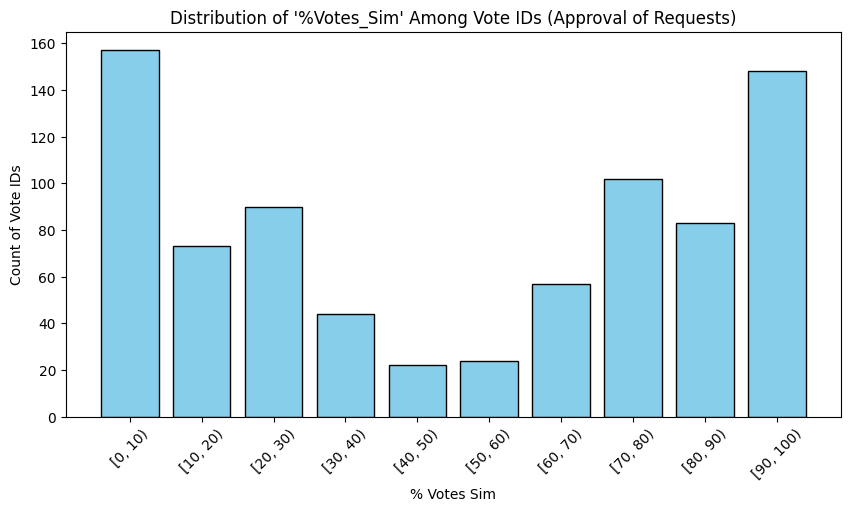

In [25]:
# Filtering the data to include only 'Approval of Requests' in 'classification'
df_approval_of_requests = vote_counts[vote_counts['classification'] == 'Approval of Requests']

# Creating bins for grouping %Votes_Sim
bins = range(0, 110, 10)  # Bins from 0% to 100% with 10% intervals
df_approval_of_requests['%Votes_Sim_Binned'] = pd.cut(df_approval_of_requests['%Votes_Sim'], bins=bins, right=False)

# Counting occurrences in each bin
vote_distribution = df_approval_of_requests.groupby('%Votes_Sim_Binned')['idvotacao'].count().reset_index()

# Renaming columns for clarity
vote_distribution.columns = ['% Votes Sim Range', 'Count of Vote IDs']

# Plot
plt.figure(figsize=(10, 5))
plt.bar(vote_distribution['% Votes Sim Range'].astype(str), vote_distribution['Count of Vote IDs'], color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel('% Votes Sim')
plt.ylabel('Count of Vote IDs')
plt.title("Distribution of '%Votes_Sim' Among Vote IDs (Approval of Requests)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show plot
plt.show()

C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_14056\2059662090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_approval_of_substitutives['%Votes_Sim_Binned'] = pd.cut(df_approval_of_substitutives['%Votes_Sim'], bins=bins, right=False)


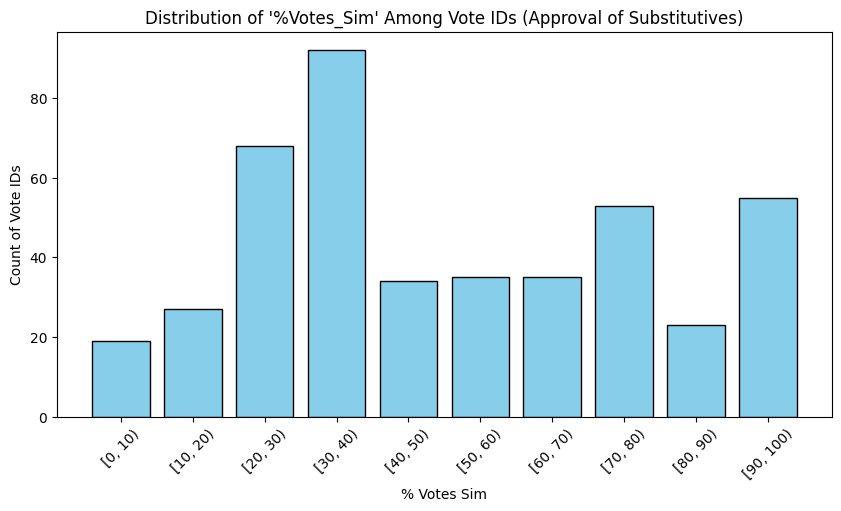

In [27]:
# Filtering the data to include only 'Approval of Requests' in 'classification'
df_approval_of_substitutives = vote_counts[vote_counts['classification'] == 'Approval of Substitutes']

# Creating bins for grouping %Votes_Sim
bins = range(0, 110, 10)  # Bins from 0% to 100% with 10% intervals
df_approval_of_substitutives['%Votes_Sim_Binned'] = pd.cut(df_approval_of_substitutives['%Votes_Sim'], bins=bins, right=False)

# Counting occurrences in each bin
vote_distribution = df_approval_of_substitutives.groupby('%Votes_Sim_Binned')['idvotacao'].count().reset_index()

# Renaming columns for clarity
vote_distribution.columns = ['% Votes Sim Range', 'Count of Vote IDs']

# Plot
plt.figure(figsize=(10, 5))
plt.bar(vote_distribution['% Votes Sim Range'].astype(str), vote_distribution['Count of Vote IDs'], color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel('% Votes Sim')
plt.ylabel('Count of Vote IDs')
plt.title("Distribution of '%Votes_Sim' Among Vote IDs (Approval of Substitutives)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show plot
plt.show()

C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_14056\4075046332.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_approval_of_final_wording['%Votes_Sim_Binned'] = pd.cut(df_approval_of_final_wording['%Votes_Sim'], bins=bins, right=False)


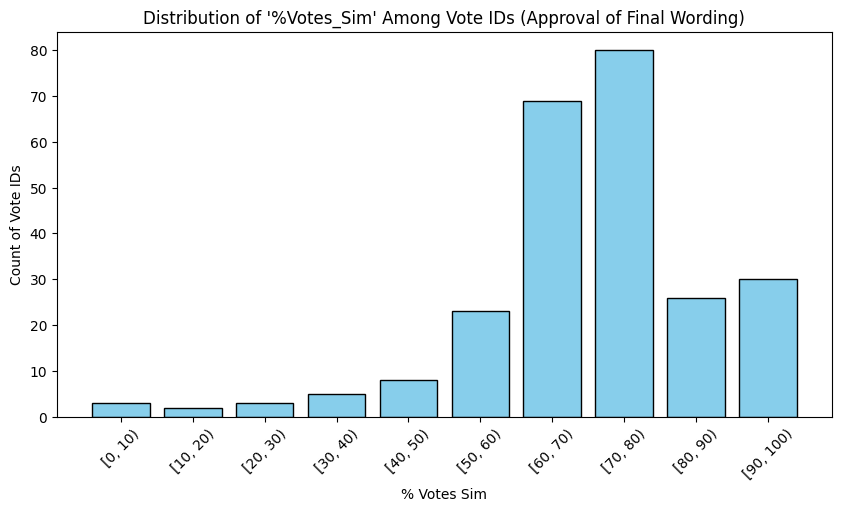

In [29]:
# Filtering the data to include only 'Approval of Requests' in 'classification'
df_approval_of_final_wording = vote_counts[vote_counts['classification'] == 'Approval of Final Wording']

# Creating bins for grouping %Votes_Sim
bins = range(0, 110, 10)  # Bins from 0% to 100% with 10% intervals
df_approval_of_final_wording['%Votes_Sim_Binned'] = pd.cut(df_approval_of_final_wording['%Votes_Sim'], bins=bins, right=False)

# Counting occurrences in each bin
vote_distribution = df_approval_of_final_wording.groupby('%Votes_Sim_Binned')['idvotacao'].count().reset_index()

# Renaming columns for clarity
vote_distribution.columns = ['% Votes Sim Range', 'Count of Vote IDs']

# Plot
plt.figure(figsize=(10, 5))
plt.bar(vote_distribution['% Votes Sim Range'].astype(str), vote_distribution['Count of Vote IDs'], color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel('% Votes Sim')
plt.ylabel('Count of Vote IDs')
plt.title("Distribution of '%Votes_Sim' Among Vote IDs (Approval of Final Wording)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show plot
plt.show()